In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
plt.style.use('bmh')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
from IPython.core.display import display, HTML
pylab.rcParams.update(params)
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler

When the shorter-term MA crosses above the longer-term MA, it's a buy signal, as it indicates that the trend is shifting up. This is known as a "golden cross."

Meanwhile, when the shorter-term MA crosses below the longer-term MA, it's a sell signal, as it indicates that the trend is shifting down. This is known as a "dead/death cross."

In [33]:
df = pd.read_csv("y_hat_final.csv")
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df.shape

(252, 2)

In [38]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))
print(short_window,long_window)

6 12


In [39]:
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

In [40]:
df.rename(columns={"y":"Close"},inplace=True)

In [41]:
signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()


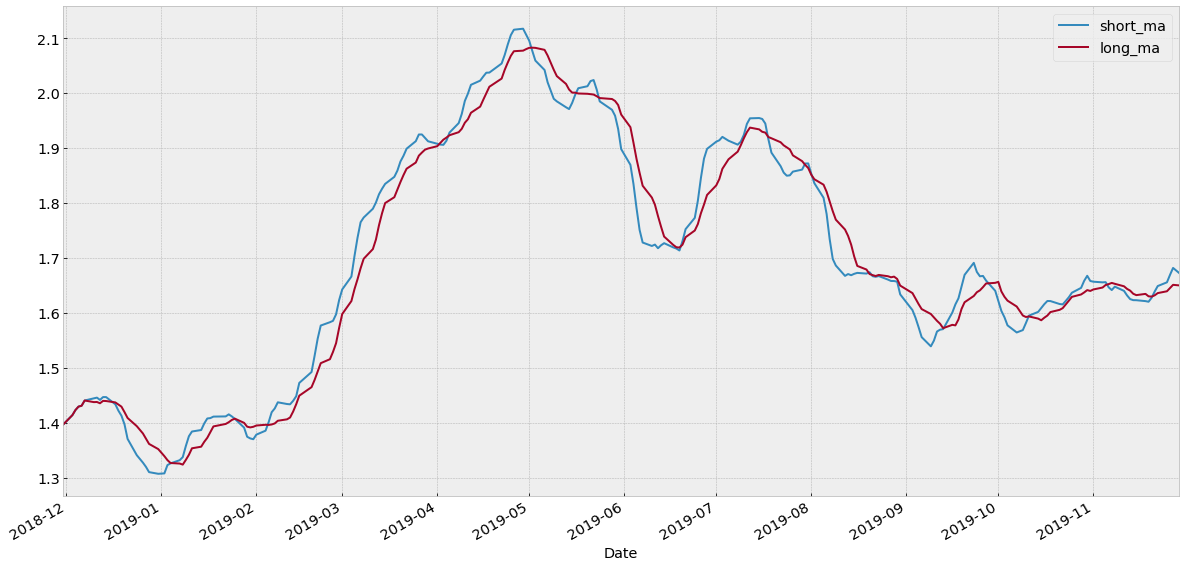

In [43]:
signals[["short_ma","long_ma"]].plot()

In [34]:
signals.signal.value_counts()

1.0    137
0.0    115
Name: signal, dtype: int64

In [61]:
signals["num"] = [x for x in (range(len(signals.index)))]

In [105]:
df.head(10)

,y_hat,Close
Date,,
2018-11-30,1.453961,1.3973
2018-12-03,1.396895,1.4315
2018-12-04,1.428154,1.4423
2018-12-05,1.439226,1.4486
2018-12-06,1.444650,1.4376
2018-12-07,1.436454,1.4886
2018-12-10,1.483793,1.4205
2018-12-11,1.422305,1.4399
2018-12-12,1.438400,1.4174


In [108]:
df.Close.iloc[0:6].mean()

1.4409833333333335

In [98]:
signals.head(50)

,signal,short_ma,long_ma,positions,num
Date,,,,,
2018-11-30,0.0,1.397300,1.397300,NaN,0
2018-12-03,0.0,1.414400,1.414400,0.0,1
2018-12-04,0.0,1.423700,1.423700,0.0,2
2018-12-05,0.0,1.429925,1.429925,0.0,3
2018-12-06,0.0,1.431460,1.431460,0.0,4
2018-12-07,0.0,1.440983,1.440983,0.0,5
2018-12-10,1.0,1.444850,1.438057,1.0,6
2018-12-11,1.0,1.446250,1.438288,0.0,7
2018-12-12,1.0,1.442100,1.435967,0.0,8


In [94]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1000,
    max_sell = 1000
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    try:
        adj = (current_inventory*real_movement[-1])
    except:
        adj = 0
            
    invest = ((initial_money + adj - starting_money) / starting_money) * 100
    total_gains = initial_money + adj - starting_money
    return states_buy, states_sell, total_gains, invest

In [95]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 6: buy 1000 units at price 1420.500000, total balance 8579.500000
day 11, sell 1000 units at price 1410.300000, investment -0.718057 %, total balance 9989.800000,
day 24: buy 1000 units at price 1339.400000, total balance 8650.400000
day 37, sell 1000 units at price 1389.000000, investment 3.703151 %, total balance 10039.400000,
day 44: buy 1000 units at price 1426.100000, total balance 8613.300000
day 83, sell 1000 units at price 1928.100000, investment 35.200898 %, total balance 10541.400000,
day 86: buy 1000 units at price 1967.900000, total balance 8573.500000
day 104, sell 1000 units at price 2016.500000, investment 2.469638 %, total balance 10590.000000,
day 115: buy 1000 units at price 2046.700000, total balance 8543.300000
day 120, sell 1000 units at price 1933.500000, investment -5.530855 %, total balance 10476.800000,
day 138: buy 1000 units at price 1787.900000, total balance 8688.900000
day 157, sell 1000 units at price 1835.400000, investment 2.656748 %, total balance 

In [96]:
total_gains

120.90000000000146

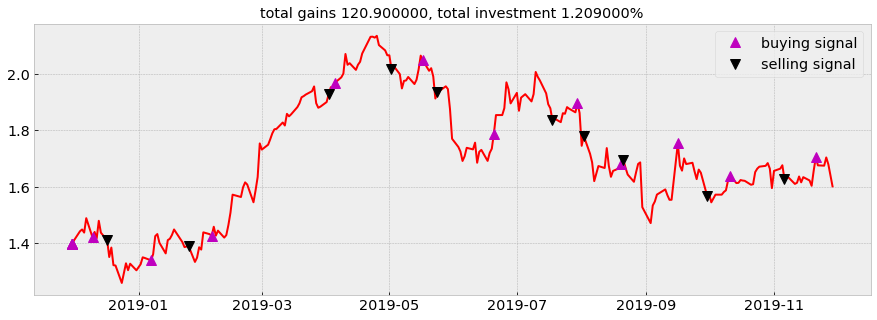

In [97]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()